### Donation Data Simulation

In [1]:
import numpy as np
import pandas as pd

In [2]:
NUM_EMAILS_SENT_WEEKLY = 3

In [3]:
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive'] #등급

In [4]:
memberYears = np.random.choice(years, 50,
                               p=[0.1,0.1,0.15,0.3,0.35])  # 50 datapoints
#샘플링. 50개 만들 것, p: 각 년도별 확률(입력한 확률들로 choice됨)
memberStats = np.random.choice(memberStatus, 50,
                                p=[0.5,0.3,0.1,0.1])

In [5]:
memberYears[:10]

array(['2015', '2015', '2015', '2017', '2018', '2016', '2015', '2018',
       '2018', '2017'], dtype='<U4')

In [6]:
memberStats[:10]

array(['bronze', 'bronze', 'bronze', 'bronze', 'silver', 'gold', 'silver',
       'gold', 'bronze', 'bronze'], dtype='<U8')

In [7]:
#각 열을 합쳐서 yearJoined 데이터프레임 생성
yearJoined = pd.DataFrame({'yearJoined':memberYears,
                           'memberStats': memberStats})

In [8]:
yearJoined.head()

,yearJoined,memberStats
0,2015,bronze
1,2015,bronze
2,2015,bronze
3,2017,bronze
4,2018,silver


##### 이메일 오픈 횟수와 기부 금액 간의 상관관계를 알아보고자 했었다..
### 이메일을 열어보는 행위에 대한 함수 생성

In [9]:
def never_opens(period_rng):
    return []

In [10]:
def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

In [11]:
def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng,
                                        np.random.uniform(1.01, 1.30))  # increasing

In [12]:
def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng,
                                        np.random.uniform(0.5, 0.99)) # decreading

In [13]:
#이메일 열어본 횟수 반환해주는 함수
def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return [] #가입한 지 일주일이 안 됐으면 빈 리스트 리턴

    times = np.random.randint(0, len(period_rng), #len(period_rng): 몇주동안 가입해있었는지 나옴. 그 중에서 10% 샘플링
                               int(0.1 * len(period_rng)))  # 10% times: 무조건 0으로 세팅해주기 위한 10퍼센트 인덱스 추출
    #times: period_rng 중 10퍼센트는 무조건 열지 않는다고 세팅.
    num_opened = np.zeros(len(period_rng)) #모두 0으로 채워줌(array 생성): shape=(9,3)해주면 행열9*3인 matirix 생성도 가능
    for prd in range(0, len(period_rng), 2): #0~주 개수까지 2개씩 채워넣겠다 #step=2
        n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1) #n:고정된 일주일에 보내는 메일수, p:0~1사이 랜덤 확률
        try:
            num_opened[prd:(prd+2)] = np.random.binomial(n, p, 2)  ## number of trials, probability of each trial, number of testment
            #두번마다 같은 확률로 testiment를 해서 이메일을 얼마나 여는지 넣어줌(step = 2)
            p = max(min(1, p*fac), 0) #p값 업데이트
            #1보다 큰 확률/0보다 작은 확률 생성 방지
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)  # data set has odd numbers of dtpoints
            #에러가 생기면 그냥 랜덤하게 하나 넣어줘라(week 개수가 홀수일 때)
    for t in range(len(times)): #times 인덱스
        num_opened[times[t]] = 0 #10퍼센트는 무조건 0으로 채워줌
    return num_opened

In [14]:
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week))+"days") + \
           pd.Timedelta(str(np.random.choice(hours_of_day)) +'hours') +\
           pd.Timedelta(str(np.random.choice(minute_of_hour))+'minutes')+ \
           pd.Timedelta(str(np.random.choice(second_of_minute))+'seconds')

In [15]:
def produce_donations(period_rng, member_behavior, num_emails,
                      use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500,
                                 1000, 1500, 2000]) #정해진 기부금액
    member_has = np.random.choice(donation_amounts) #기부 금액에서 멤버가 얼마를 가지고 있는지

    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY* len(period_rng)) # opened rate 
    member_gives = member_has * email_fraction #기부 금액 = 멤버가 가진 돈*이메일 오픈 비율
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1] #반환된 기부금액이 기부가능한 금액들 중 어느 금액보다 크거나 같은지 그 인덱스 값 반환. 
    # 튜플로 반환된 인덱스 중 마지막 것 뽑음 -> 기부 가능한 금액 알 수 있음.ex) 250달러와 500달러 사이
    num_times_gave = np.random.poisson(2)*(2018-member_join_year)  # poisson distribution -- how many times member gives
    times = np.random.randint(0, len(period_rng), num_times_gave)  # which week member give donation
    
    #기부데이터 프레임 만들어줌
    dons = pd.DataFrame({'member':[],
                         'amount':[],
                         'timestamp':[]})
    for n in range(num_times_gave): #기부 횟수 넣어줌
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)] #예상 기부 금액: 30%확률로 ~를 기부할 것이다.라는 것
        ts = str(period_rng[times[n]] + random_weekly_time_delta())  # ramdom day in the week(일주일 간 어느 날짜에 기부했는지, 기부 날짜 랜덤 반환)
        dons = dons.append(pd.DataFrame({
            'member':[use_id],
            'amount':[donation],
            'timestamp':[ts] }))

    if dons.shape[0] >0:
        dons = dons[dons.amount != 0] #shape==0이면 기부하지 않았다는 뜻
        #따라서 0이 아닌 것들만 걸러내서 return
    return dons

### 생성 코드 실행

In [16]:
## run it
# 이메일 열어본 횟수와 기부 금액의 상관관계를 보고자 함
# 이메일에 관한 동작들 정의
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]

# numpy.random.choice(a, size=None, replace=True, p=None) #sampling
member_behaviors = np.random.choice(behaviors, size=50, p=[0.2, 0.5, 0.1, 0.2]) #확률 지정, 50개 샘플링
rng = pd.date_range('2015-02-04', '2018-06-01', freq='W') # 주 단위, 날짜 범위 지정
# 2015년 2월 4일에 설립된 기부단체, 현재는 2018-06-01

emails = pd.DataFrame({'member':[],
                       'week':[],
                       'emailsOpened':[]})

donations = pd.DataFrame({'member':[],
                          'amount':[],
                          'timestamp':[]})

print(yearJoined.iloc[0])

yearJoined       2015
memberStats    bronze
Name: 0, dtype: object


In [17]:
for idx in range(yearJoined.shape[0]): #yearJoined.shape()->(50,2): "멤버 수", 컬럼 수 

    # time stamp + time delta
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + \
                pd.Timedelta(str(np.random.randint(0, 365)) + 'days') # randomly add some days
                #타임데이터 생성
    join_date = min(join_date, pd.Timestamp('2018-06-01')) # max_range is 2018-06-02
    # 현재 최신 날짜보다 클 경우를 방지. 가능한 최대 날짜 설정
    member_rng = rng[rng >join_date]
    # 가입한 날짜 이후 주부터 현재 날짜 이전 주까지의 타임스탬프 반환

    if len(member_rng) <1:
        continue

    info = member_behaviors[idx](member_rng)  # generate member opened email numbers

    if len(info) == len(member_rng): #개수 동일하게 생성했으나 한번 더 체크
        emails = emails.append(pd.DataFrame({
            'member': [idx] *len(info),
            'week': [str(r) for r in member_rng],
            'emailsOpened': info #이메일 열어본 횟수
        }))
        #donation 데이터 생성
        donations = donations.append(
            produce_donations(member_rng, member_behaviors[idx],
                              sum(info), idx, join_date.year) #멤버레인지,멤버행동,열어본이메일개수합,멤버인덱스,가입년도
        )

In [18]:
## get rid of zero donations and zero emails
emails = emails[emails.emailsOpened != 0] #이메일 오픈 횟수 0인 것 제거
yearJoined.index.name = 'user'

In [19]:
yearJoined.to_csv('data/year_joined.csv', index=False)
donations.to_csv('data/donations.csv',   index=False)
emails.to_csv('data/emails.csv',  index=False)

### test

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./data/donations.csv')
print(df.iloc[1:4])

   member  amount            timestamp
1     0.0    25.0  2017-10-21 17:52:12
2     0.0    25.0  2017-09-10 12:08:41
3     4.0    25.0  2016-02-29 12:42:52


In [21]:
df.set_index(pd.to_datetime(df.timestamp), inplace=True)
print(df.iloc[1:4])

                     member  amount            timestamp
timestamp                                               
2017-10-21 17:52:12     0.0    25.0  2017-10-21 17:52:12
2017-09-10 12:08:41     0.0    25.0  2017-09-10 12:08:41
2016-02-29 12:42:52     4.0    25.0  2016-02-29 12:42:52


In [22]:
df.sort_index(inplace=True)
print(df.iloc[1:4])

                     member  amount            timestamp
timestamp                                               
2015-08-27 14:03:16    39.0   250.0  2015-08-27 14:03:16
2015-10-21 14:48:33    11.0    25.0  2015-10-21 14:48:33
2015-11-02 20:41:42    41.0   100.0  2015-11-02 20:41:42


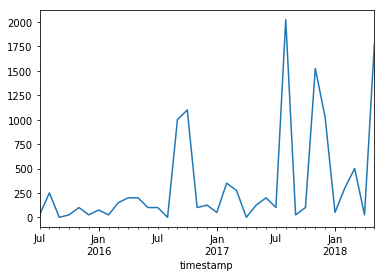

In [23]:
df.groupby(pd.Grouper(freq='M')).amount.sum().plot()
plt.show()